In [268]:
import warnings
warnings.filterwarnings('ignore')

# Activity Comparison
In this notebook we look at activity levels from participants from the UT1000, UT2000, and UTx000 studies. 

In [269]:
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

from scipy import stats
from scipy.stats import linregress

# Table of Contents
1. [Data Import](#data_import)
    1. [Target Data: Fitbit Sleep](#targets)
    2. [Feature Data: Fitbit Activity](#features)
2. [Pre-Processing](#preprocessing)
    1. [Target Data](#target_data)
        1. Summary
        1. Scaling
    2. [Feature Data](#feature_data)
3. [Analyzing Relationships](#analysis)

In [270]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='data_import'></a>

# Constant Participation
We might check to see if there are any participants that have been in all three studes.

## Importing EIDs
The only ID that would link participants across studies _for certain_ would be their EIDs. The REDCap database has all this information.

In [271]:
eids_1 = pd.read_csv("../data/raw/ut1000/admin/participant_eids.csv")
eids_2 = pd.read_csv("../data/raw/ut2000/admin/participant_eids.csv")
eids_x = pd.read_csv("../data/raw/utx000/admin/participant_eids.csv")

## Comparing Participants Across Studies
Now we can compare the EIDs across studies and see what overlap we have. 

In [272]:
from functools import reduce

dfs = [eids_1,eids_x]
one_and_x = reduce(lambda left,right: pd.merge(left,right,on='uteid'), dfs)
print("Number of Participants from both studies:",len(one_and_x))

Number of Participants from both studies: 4


<div class="alert alert-block alert-success">
    
We have **four** participants from both the UT1000 and UTx000 study.
    
</div>

In [273]:
dfs = [eids_1,eids_2]
one_and_two = reduce(lambda left,right: pd.merge(left,right,on='uteid'), dfs)
print("Number of Participants from both studies:",len(one_and_two))

Number of Participants from both studies: 28


<div class="alert alert-block alert-success">
    
We have **28** people from both the UT1000 and UT2000 studies
    
</div>

In [274]:
dfs = [eids_2,eids_x]
two_and_x = reduce(lambda left,right: pd.merge(left,right,on='uteid'), dfs)
print("Number of Participants from both studies:",len(two_and_x))

Number of Participants from both studies: 0


<div class="alert alert-block alert-danger">
    
We have **NO** overlap between the UT2000 and UTx000 studies which also means we have no participant who participated in all three studies. 
    
</div>

<a id='aggregate'></a>

# Pre-Processing
We need to do a little pre-processing in order to massage the data into a form that can be used.

## Data Importing and Cleaning

### UT1000
Data are summarized in the `dailyActivity` file.

In [275]:
u1_raw = pd.read_csv("../data/raw/ut1000/fitbit/dailyActivity_merged.csv",parse_dates=["ActivityDate"],infer_datetime_format=True)
u1_raw.drop(["TrackerDistance","VeryActiveDistance","ModeratelyActiveDistance","LightActiveDistance","SedentaryActiveDistance","LoggedActivitiesDistance","Floors","MarginalCalories","RestingHeartRate","CaloriesBMR"],axis="columns",inplace=True)
u1_raw.columns = ["id","timestamp","steps","distance","very_active_minutes","fairly_active_minutes","lightly_active_minutes","sedentary_minutes","calories"]
    
u1_raw.head()

,id,timestamp,steps,distance,very_active_minutes,fairly_active_minutes,lightly_active_minutes,sedentary_minutes,calories
0,1025,2018-10-29,3989,2.95,5,6,100,1329,2028
1,1025,2018-10-30,7633,5.64,6,12,176,900,2416
2,1025,2018-10-31,5497,4.06,7,3,184,671,2436
3,1025,2018-11-01,8534,6.31,12,9,215,878,2560
4,1025,2018-11-02,6512,4.81,0,0,211,637,2346


### UT2000
Now daily activity file exists for this study nor is the Fitabase account active to retrieve it from. Therefore, we have to import the individual files and concatenate them.

In [276]:
# steps
u2_steps = pd.read_csv("../data/raw/ut2000/fitbit/dailySteps_merged.csv",parse_dates=["ActivityDay"],infer_datetime_format=True)
# intensities
u2_int = pd.read_csv("../data/raw/ut2000/fitbit/dailyIntensities_merged.csv",parse_dates=["ActivityDay"],infer_datetime_format=True)
u2_int["distance"] = u2_int[[column for column in u2_int.columns if column.endswith("Distance")]].sum(axis="columns")
# calories
u2_cal = pd.read_csv("../data/raw/ut2000/fitbit/dailyCalories_merged.csv",parse_dates=["ActivityDay"],infer_datetime_format=True)
# combining and cleaning
u2_raw = reduce(lambda left,right: pd.merge(left,right,on=["Id","ActivityDay"]), [u2_steps,u2_int,u2_cal])
u2_raw.drop([column for column in u2_raw.columns if column.endswith("Distance")],axis="columns",inplace=True)
u2_raw.columns = ["id","timestamp","steps","sedentary_minutes","lightly_active_minutes","fairly_active_minutes","very_active_minutes","distance","calories"]
u2_raw.head()

,id,timestamp,steps,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes,distance,calories
0,2030,2019-03-11,56,847,1,0,0,0.01,796
1,2040,2019-03-11,2947,1393,15,15,17,1.95,1510
2,2040,2019-03-12,8538,978,178,10,5,5.63,1933
3,2040,2019-03-13,5970,1014,147,8,17,3.94,1846
4,2040,2019-03-14,10480,1120,296,14,10,6.95,2210


### UTX000

In [277]:
ux_raw = pd.read_csv("../data/processed/fitbit-daily-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
ux_raw.drop(["calories_from_activities","bmi","bmr","fat","weight","food_calories_logged","water_logged"],axis="columns",inplace=True)
ux_raw.head()

,timestamp,calories,steps,distance,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes,beiwe
0,2020-05-13,2781.0,9207,4.396294,1241,70,118,11,hfttkth7
1,2020-05-14,3727.0,15207,7.261114,614,263,134,23,hfttkth7
2,2020-05-15,3909.0,14556,8.028501,577,205,57,108,hfttkth7
3,2020-05-16,3927.0,18453,8.748670,760,176,24,151,hfttkth7
4,2020-05-17,4180.0,15425,7.973149,605,207,50,131,hfttkth7


## Including Additional Columns
There are a few extra pieces of information that we might want to include, like:
* **Day of Week** (`dow`): Can help us group the data by day and by weekday/weekend

In [278]:
u1 = u1_raw.drop("id",axis="columns").reset_index(drop=True)
u2 = u2_raw.drop("id",axis="columns").reset_index(drop=True)
ux = ux_raw.drop("beiwe",axis="columns").reset_index(drop=True)

act = {"ut1000":u1,"ut2000":u2,"utx000":ux}

for df in act.values():
    df["timestamp"] = pd.to_datetime(df["timestamp"]) # making sure timestamp is datetime
    df["dow"] = df["timestamp"].dt.strftime("%a") # getting day of week column
    

# Comparing Aggregate Measures
We start by comparing aggregate measurements of activity between studies.

## Study Aggregates
Here we look at the most general aggregates of the data between studies:
1. Mean
2. Median

### Summary DataFrame
This DataFrame includes summary measurements from each study for each of the _important_ activity metrics.

In [279]:
metrics = [column for column in u1.columns if column not in ["timestamp","dow","bmr","calories","id"]]
summary = {metric: [] for metric in metrics}
summary["study"] = []
summary["aggregate"] = []

for study, data in act.items():
    for agg, f in zip(["mean","median"],[np.mean,np.median]):
        summary["study"].append(study)
        summary["aggregate"].append(agg)
        for metric in metrics:
            summary[metric].append(f(data[metric]))
        
summary_act = pd.DataFrame(summary)

### Combined DataFrame
For later analysis, we might be interested in using a DataFrame that contains all the observations from each of the three studies.

In [280]:
for study, data in act.items():
    data["study"] = study
combined_act = pd.concat([u1,u2,ux])

### Visualizing
We can look at the study aggregates with bar plots to get a sense of the differences

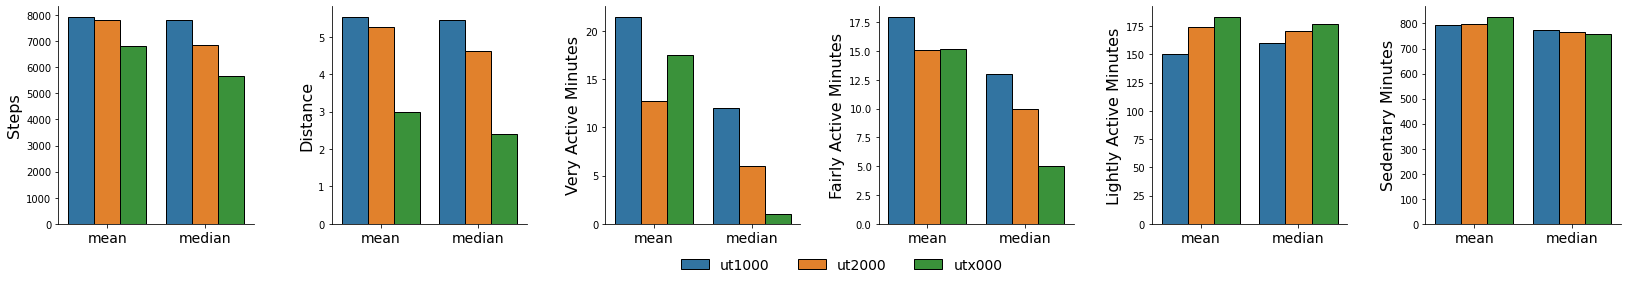

In [281]:
fig, axes = plt.subplots(1,6,figsize=(28,4))
for metric, ax in zip(metrics, axes.flat):
    sns.barplot(x="aggregate",y=metric,hue="study",edgecolor="black",data=summary_df,ax=ax)
    # x-axis
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
    # y-axis
    ax.set_ylabel(metric.replace("_"," ").title(),fontsize=16)
    # remainder
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    if metric == "fairly_active_minutes":
        ax.legend(frameon=False,title=None,bbox_to_anchor=(0.7,-0.1),ncol=3,fontsize=14)
    else:
        ax.get_legend().remove()
    
plt.subplots_adjust(wspace=0.4)
plt.show()
plt.close()

<div class="alert alert-block alert-success">
    
At least on an aggregate level, the participants in the UTx000 study tended to be less active, logging lower mean and median `steps`, `distance`, `very_active_minutes`, and `fairly_active_minutes` measurements.
    
</div>

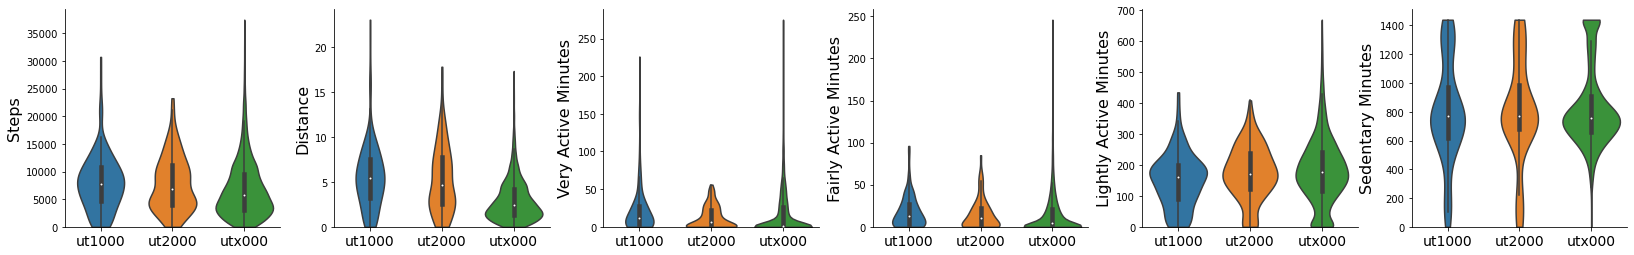

In [282]:
fig, axes = plt.subplots(1,6,figsize=(28,4))
for metric, ax in zip(metrics, axes.flat):
    sns.violinplot(x="study",y=metric,data=combined_act,cut=0,ax=ax)
    # x-axis
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
    # y-axis
    ax.set_ylabel(metric.replace("_"," ").title(),fontsize=16)
    ax.set_ylim(bottom=0)
    # remainder
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
        
plt.subplots_adjust(wspace=0.25)
plt.show()
plt.close()

## By DoW
Now we can look based on the day of the week.

In [283]:
act_by_dow = combined_act.groupby(["dow","study"]).mean().reset_index()

### Visualizing

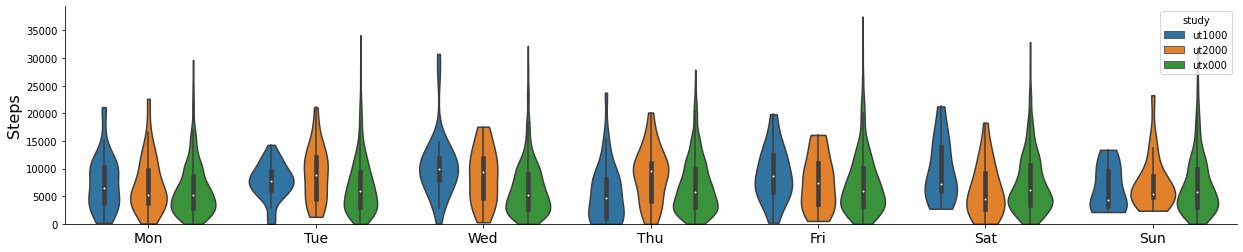

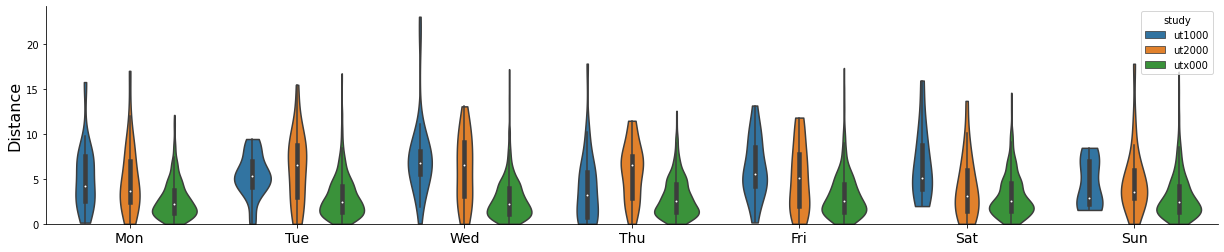

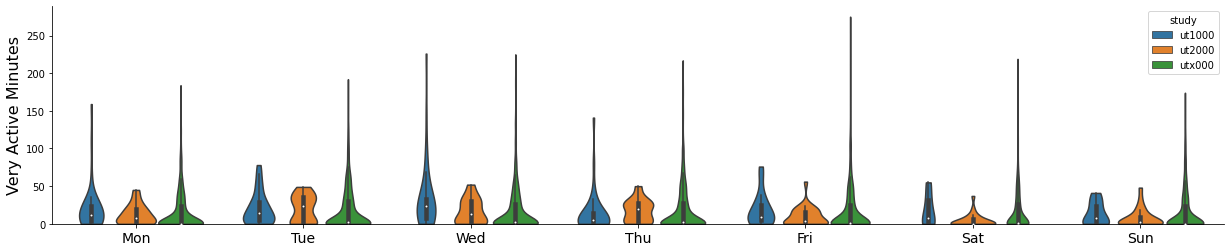

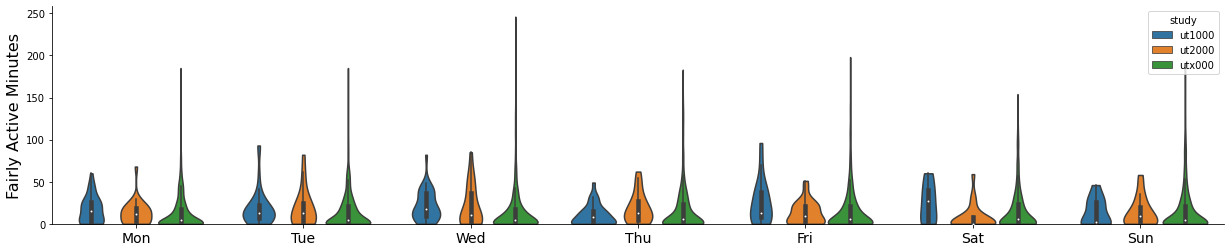

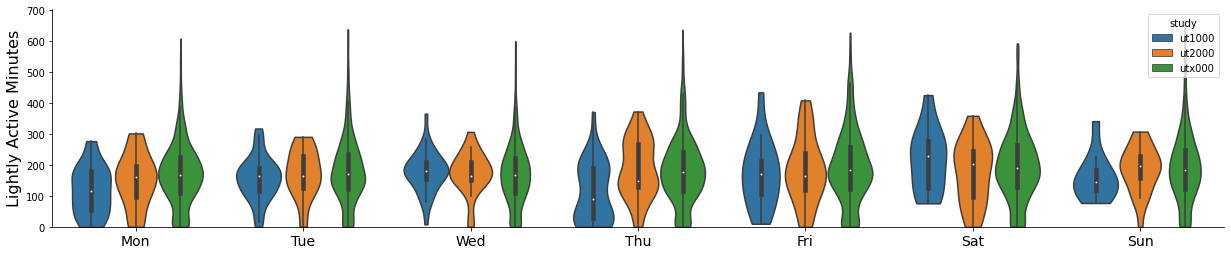

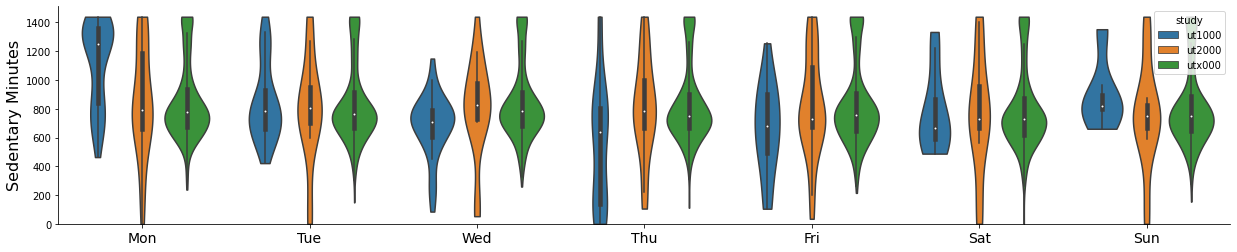

In [284]:
for metric in metrics:
    fig, ax = plt.subplots(figsize=(21,4))
    sns.violinplot(x="dow",y=metric,hue="study",data=combined_act,cut=0,ax=ax)
    # x-axis
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
    # y-axis
    ax.set_ylabel(metric.replace("_"," ").title(),fontsize=16)
    ax.set_ylim(bottom=0)
    # remainder
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)

# Comparing UT1000 to UTx000
We now look at the four participants who were in both the UT1000 and UTx000 studies.

## Gathering Pertinent Data
Although we have four participants registered in both studies, we have to first make sure that all participant received/used a Fitbit.

### Combining IDs from each study
Have to link based on EIDs.

In [312]:
u1_id_key = pd.read_csv("../data/raw/ut1000/admin/id_crossover.csv",usecols=range(0,5))
ux_id_key = pd.read_excel("../data/raw/utx000/admin/id_crossover.xlsx")
u1x_id_key = pd.merge(left=u1_id_key,right=ux_id_key,on=["eid"],suffixes=["_u1","_ux"])

### Data from UT1000 Participants
We use the `id` column from the UT1000 study and cross-reference that with the `record` ID from the ID key file.

In [327]:
u1_long_data = u1_raw[u1_raw["id"].isin(u1x_id_key["record"])]
u1_long_data = u1_long_data.merge(u1x_id_key[["record","eid"]],left_on=["id"],right_on=["record"],how="inner").drop(["record","id"],axis="columns")
print("Number of active participants:", len(u1_long_data["eid"].unique()))

Number of active participants: 1


### Data from UTx000 Participants
We use the `beiwe` column from the UTx000 study with the `beiwe_ux` column from the ID key file. 

In [328]:
ux_long_data = ux_raw[ux_raw["beiwe"].isin(u1x_id_key["beiwe_ux"])]
ux_long_data = ux_long_data.merge(u1x_id_key[["beiwe_ux","eid"]],left_on=["beiwe"],right_on=["beiwe_ux"],how="inner").drop(["beiwe","beiwe_ux"],axis="columns")
print("Number of active participants:", len(ux_long_data["eid"].unique()))

Number of active participants: 3


### Combined Dataset
Now we see the overlap.

In [329]:
u1x_participants = [pt for pt in u1_long_data["eid"].unique() if pt in ux_long_data["eid"].unique()]
print("Number of participants:", len(u1x_data["eid"].unique()))

Number of participants: 1


<div class="alert alert-block alert-danger">
    
Unfortunately, out of the four possible participants, we only have **one** participant that actively collected activity data in both studies. 
    
</div>

In [343]:
u1_overlap = u1_long_data[u1_long_data["eid"].isin(u1x_participants)].drop(["eid"],axis="columns")
ux_overlap = ux_long_data[ux_long_data['eid'].isin(u1x_participants)].drop(["eid"],axis="columns")
u1x_data = {"ut1000":u1_overlap,"utx000":ux_overlap}
print("Number of Observations:")
for study, data in u1x_data.items():
    print(f"\t{study}: {len(data)}")

Number of Observations:
	ut1000: 12
	utx000: 129
